<a href="https://colab.research.google.com/github/maddogmikeb/Jira/blob/master/UltimateSprintReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [255]:
# install dependencies

from IPython.core.display import clear_output

!pip install -q atlassian-python-api
!pip install -q matplotlib
!pip install -q numpy
!pip install -q tqdm

clear_output()

In [275]:
from atlassian import Jira
from urllib.parse import urlparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import base64
import io
import re
import json
from datetime import datetime
import datetime as dt
import pytz
import tzlocal
from dateutil import parser
import copy
import pandas as pd
import math
from tqdm.auto import tqdm

class DataPoint:
    def __init__(self, name, count, points, color, hatch, edge_color):
        self.name = name
        self.count = count
        self.points = points
        self.color = color
        self.hatch = hatch
        self.edge_color = edge_color

    def get_values(self):
        return [self.count, self.points]

class UltimateSprintReport:

  def __init__(self, username, password, jira_url):
    self.jira = Jira(
        url=jira_url,
        username=username,
        password=password,
        cloud=True
      )

  def load(self, sprint_report_url):

    self.progress_bar = tqdm(total=100, desc='Loading Sprint Details', leave=True)
    self.progress_bar.n = 0
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading sprint details")
    self._set_sprint_details(sprint_report_url)
    self.progress_bar.n = round((1/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading status categories")
    self._load_status_categories()
    self.progress_bar.n = round((2/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading sprint report")
    self._load_sprint_report()
    self.progress_bar.n = round((3/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading velocity statistics")
    self._load_velocity_statistics()
    self.progress_bar.n = round((4/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading board configuration")
    self._load_board_config()
    self.progress_bar.n = round((5/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading sprint statistics")
    self._load_sprint_statistics()
    self.progress_bar.n = round((6/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading committed vs planned chart")
    self._load_committed_vs_planned_chart()
    self.progress_bar.n = round((7/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading sprint details")
    self._calculate_sprint_details()
    self.progress_bar.n = round((8/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading sprint predictability")
    self._calculate_sprint_predictability()
    self.progress_bar.n = round((9/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading epic statistics")
    self._calculate_epic_statistics()
    self.progress_bar.n = round((10/11) * 100, 2)
    self.progress_bar.refresh()

    self.progress_bar.set_postfix_str("Loading burndown chart")
    self._load_burndown()

    self.progress_bar.n = round((11/11) * 100, 2)
    self.progress_bar.refresh()
    self.progress_bar.set_postfix_str("Completed")

    self.progress_bar.clear()
    self.progress_bar.container.close()
    self.progress_bar.close()

    return self

  def _set_sprint_details(self, sprint_report_url):
    self.sprint_report_url = sprint_report_url
    self.base_url, self.project, self.rapidViewId, self.sprintId = self._parse_url(sprint_report_url)
    return self

  def _format_key_as_browse(self, key):
    return '<a href="' + self.base_url + "/browse/" + key + '" target="_blank">' + key + '</a>'

  def _load_burndown(self):
    scope = []
    scopeChanges = []

    tmpSet = set()
    issueNames = []
    alreadyDone = set()

    scopeChangeBurndownChart = json.loads(
      self.jira.request(
          absolute=True,
          method="GET",
          path="{base_url}{path}?rapidViewId={rapidViewId}&sprintId={sprintId}".format(
              base_url = self.base_url,
              path="/rest/greenhopper/1.0/rapid/charts/scopechangeburndownchart.json",
              rapidViewId=self.rapidViewId,
              sprintId=self.sprintId
              )
          ).content
      )

    sprintStart = scopeChangeBurndownChart['startTime']
    sprintEnd = scopeChangeBurndownChart['endTime']
    completeTime = scopeChangeBurndownChart['completeTime'] if 'completeTime' in scopeChangeBurndownChart else None
    now = scopeChangeBurndownChart['now'] if 'now' in scopeChangeBurndownChart else None

    alreadyCheckedForResolution = set()

    self.progress_bar.update(round(100/110, 2))

    total = len(scopeChangeBurndownChart['changes'].items()) * 2
    counter = -1

    for ts, changelist in scopeChangeBurndownChart['changes'].items():
        counter += 1
        self.progress_bar.n = round(((10 + (counter/total))/11) * 100, 2)
        self.progress_bar.refresh()

        timestamp = int(ts)
        for change in changelist:
            if change['key'] in alreadyDone:
                continue

            if ('column' in change and 'done' in change['column'] and timestamp <= sprintStart):
                alreadyDone.add(change['key'])

            if (change['key'] not in alreadyCheckedForResolution):
                self.progress_bar.set_postfix_str("Loading issue details: " + change['key'])
                issue = self.jira.issue(key=change['key'], fields="resolutiondate")
                alreadyCheckedForResolution.add(change['key'])
                if (issue and 'fields' in issue and 'resolutiondate' in issue['fields'] and issue['fields']['resolutiondate']):
                    resolution_epoch = datetime.strptime(issue['fields']['resolutiondate'], "%Y-%m-%dT%H:%M:%S.%f%z").timestamp() * 1000
                    if resolution_epoch <= sprintStart:
                        alreadyDone.add(change['key'])

    for ts, changelist in sorted(scopeChangeBurndownChart['changes'].items(), key = lambda x: x):
        counter += 1
        self.progress_bar.n = round(((10 + (counter/total))/11) * 100, 2)
        self.progress_bar.refresh()

        timestamp = int(ts)
        for change in changelist:
            # Skip parent issues
            if change['key'] in scopeChangeBurndownChart['issueToParentKeys']:
              continue

            # Ignore issues that were already completed before the sprint had started
            if change['key'] in alreadyDone:
                continue

            statistic = np.nan
            lastStatus = ""

            if timestamp <= sprintStart:
                statistic = change['statC']['newValue'] if 'statC' in change and 'newValue' in change['statC'] else np.nan
                if change['key'] in [x['key'] for x in scope]:
                    for i in range(len(scope)):
                        if scope[i]['key'] == change['key']:
                            if np.isnan(scope[i]['statistic']):
                                scope[i]['statistic'] = float(statistic)
                            elif not np.isnan(statistic):
                                scope[i]['statistic'] += float(statistic)
                else:
                    scope.append({
                        'timestamp': sprintStart,
                        'key': change['key'],
                        'eventType': 'Sprint start',
                        'eventDetail': '',
                        'statistic': float(statistic)
                    })

            elif (completeTime and timestamp <= completeTime) or (now and timestamp <= now):
                if change['key'] in [x['key'] for x in scope]:
                    statistic = 0
                    for i in range(len(scope)):
                        if scope[i]['key'] == change['key']:
                            if np.isnan(scope[i]['statistic']):
                                #statistic = np.nan
                                pass
                            else:
                                if float(scope[i]['statistic']) == 0:
                                  statistic += 0
                                else:
                                  statistic += -1 * float(scope[i]['statistic'])
                            if (change['key'] == "FDSEWMSR-17371"):
                                #print(["scope:" , statistic, scope[i]])
                                pass
                            lastStatus = scope[i]['eventDetail']

                if (change['key'] == "FDSEWMSR-17371"):
                  #print(["statisitc:" , statistic])
                  pass

                if lastStatus == "Issue removed from sprint":
                  if "added" in change and change["added"] == True:
                    pass # if being readded to the sprint
                  else:
                    continue

                if "column" in change and 'done' in change['column']:
                  if not np.isnan(statistic) and statistic != 0:
                    statistic = -1 * abs(statistic) # ensure its burning down
                  if (change['key'] == "FDSEWMSR-17371"):
                      #print(["burndown statisitc:" , statistic])
                      pass
                  scope.append({
                      'timestamp' : timestamp,
                      'key' : change['key'],
                      'eventType': "Burndown",
                      'eventDetail': 'Issue completed',
                      'statistic': statistic
                  })
                elif "added" in change and change["added"] == False:
                  if not np.isnan(statistic) and statistic != 0:
                    statistic = -1 * abs(statistic) # ensure its burning down
                  scope.append({
                      'timestamp' : timestamp,
                      'key' : change['key'],
                      'eventType': "Scope change",
                      'eventDetail': 'Issue removed from sprint',
                      'statistic': statistic
                  })
                elif 'added' in change and change['added'] == True:
                    scope.append({
                        'timestamp' : timestamp,
                        'key' : change['key'],
                        'eventType': "Scope change",
                        'eventDetail': 'Issue added to sprint',
                        'statistic': np.nan
                    })
                elif 'statC' in change and 'newValue' in change['statC']:
                  statistic = change['statC']['newValue'] if 'statC' in change and 'newValue' in change['statC'] else np.nan
                  if (statistic != 0 and not np.isnan(statistic)):
                    if 'oldValue' in change['statC']:
                      oldValue = change['statC']['oldValue']
                      scope.append({
                          'timestamp' : timestamp,
                          'key' : change['key'],
                          'eventType': "Scope change",
                          'eventDetail': f'Esimate change from {oldValue} to {statistic}',
                          'statistic': statistic - oldValue
                      })
                    else:
                      scope.append({
                          'timestamp' : timestamp,
                          'key' : change['key'],
                          'eventType': "Scope change",
                          'eventDetail': f'Esimate of {statistic} has been added',
                          'statistic': statistic
                      })
                elif 'statC' in change and 'oldValue' in change['statC'] and not 'newValue' in change['statC']:
                  scope.append({
                      'timestamp' : timestamp,
                      'key' : change['key'],
                      'eventType': "Scope change",
                      'eventDetail': f'Estimate of {abs(statistic)} has been removed',
                      'statistic': statistic
                  })
                elif 'statC' in change and change['statC'] == {} and 'column' in change and 'notDone' in change['column'] and 'newStatus' in change['column']:
                  newStatusId = change['column']['newStatus']
                  scope.append({
                      'timestamp' : timestamp,
                      'key' : change['key'],
                      'eventType': "Status change",
                      'eventDetail': f'Status changed to {newStatusId}',
                      'statistic': np.nan
                  })
                elif 'column' in change and 'notDone' in change['column'] and not change['column']['notDone']:
                  scope.append({
                      'timestamp' : timestamp,
                      'key' : change['key'],
                      'eventType': "Status change",
                      'eventDetail': f'Status change',
                      'statistic': np.nan
                  })
                else:
                  scope.append({
                      'timestamp' : timestamp,
                      'key' : change['key'],
                      'eventType': "UNKNOWN",
                      'eventDetail': 'UNKNOWN',
                      'statistic': statistic
                  })

            #if change['key'] not in tmpSet:
            #    tmpSet.add(change['key'])
            #    issueNames.append(change['key']);

    for ts, closures in scopeChangeBurndownChart['openCloseChanges'].items():
        timestamp = int(ts)
        # if timestamp < completeTime:
        for closure in closures:
          if ('operation' not in closure):
              continue
          operation = closure['operation'].lower()
          by = closure['userDisplayNameHtml']
          name = re.search(r'>(.*?)<', by).group(1)
          if (timestamp == completeTime):
            operation = "ended"
            scope.append({
                'timestamp' : timestamp,
                'key' : "",
                'eventType': f"Sprint ended by {name}",
                'eventDetail': '',
                'statistic': np.nan
            })
          elif (timestamp < completeTime):
            scope.append({
                'timestamp' : timestamp,
                'key' : "",
                'eventType': f"Sprint {operation} by {name}",
                'eventDetail': '',
                'statistic': np.nan
            })
    if completeTime:
      by = scopeChangeBurndownChart['lastUserWhoClosedHtml']
      name = re.search(r'>(.*?)<', by).group(1)
      scope.append({
          'timestamp' : completeTime,
          'key' : "",
          'eventType': f"Sprint ended by {name}",
          'eventDetail': '',
          'statistic': np.nan
      })

    scope.append({
        'timestamp': sprintStart + 0.1,
        'key' : "",
        'eventType': f"Sprint started",
        'eventDetail': '',
        'statistic': np.nan
    })

    if now and ((completeTime and now < completeTime) or not completeTime):
      scope.append({
          'timestamp': now,
          'key' : "",
          'eventType': f"Current",
          'eventDetail': '',
          'statistic': np.nan
      })

    scope.sort(key = lambda x: (x['timestamp'], x['key']) )

    df = pd.DataFrame(scope)

    def make_clickable(val):
        if val != "":
          return f'<a target="_blank" href="{self.base_url}/browse/{val}">{val}</a>'
        else:
          return val

    df['Inc.'] = df.apply(lambda row: row.statistic if row.statistic >= 0 else "", axis = 1)
    df['Dec.'] = df.apply(lambda row: row.statistic if row.statistic < 0 else "", axis = 1)

    df['statistic_copy'] = df['statistic']
    df.fillna( {'statistic_copy': 0}, inplace=True)
    df['Remaining'] = df['statistic_copy'].cumsum()
    df = df.drop('statistic_copy', axis=1)
    df = df.drop('statistic', axis=1)
    df['date'] = pd.to_datetime(df['timestamp']/1000, unit='s')
    df['timestamp'] = df['timestamp'].astype('string').str.split('.').str[0]
    df['key'] = df['key'].apply(make_clickable)

    df = df.rename(columns={"date": "Date", "key": "Issue", "eventType": "Event Type", "eventDetail": "Event Detail"})

    df = df[['timestamp', 'Date', 'Issue', 'Event Type', 'Event Detail', 'Inc.', 'Dec.', 'Remaining']]

    filtered_df = df[df["Event Type"] != "Sprint start"]

    x = filtered_df["Date"]
    y = filtered_df["Remaining"]

    plt.step(x, y, label='Remaining', where='post')

    guideline_end_date = pd.Timestamp(sprintEnd / 1000, unit='s')
    guideline_start_date = pd.Timestamp(sprintStart / 1000, unit='s')
    plt.plot([guideline_start_date, guideline_end_date], [y.iloc[0], 0], 'r--', label='Guideline')

    plt.grid(axis='x', color='0.95')
    plt.xticks(rotation=45)

    plt.axhline(y=0, color='black', linestyle='-')

    # add now line to chart if not completed and we are given the now timestamp
    if now and ((completeTime and now < completeTime) or not completeTime):
      plt.axvline(x=pd.to_datetime(now/1000, unit='s'), color='green', linestyle='--', linewidth=0.25, label='Now')

    plt.legend()
    plt.title('Burndown Chart')

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', pad_inches=0.5)
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close()

    self.burndown_table = df
    self.burndown_chart = f'<img id="burndown_chart" class="popupable" src="data:image/png;base64,{image_base64}" alt="Committed vs Planned"/>'

    return self

  def _calculate_epic_statistics(self):
    epic_stats = []

    estimation_field = self.board_config['estimationStatisticConfig']['currentEstimationStatistic']['id'].replace('field_', '', 1)

    epics_being_worked_on = []
    for issue in self.sprint_report['contents']['completedIssues']:
      if issue['typeName'] == "Epic":
        epics_being_worked_on.append(issue['key'])
      elif 'epic' in issue:
        epics_being_worked_on.append(issue['epic'])

    for epic_key in list(set(epics_being_worked_on)):
      self.progress_bar.set_postfix_str("Loading issue details: " + epic_key)
      epic = self.jira.issue(key=epic_key)
      issues_in_epic = self.jira.jql(
        jql='issue in portfolioChildIssuesOf("' + epic_key + '")',
        fields=','.join(["status", estimation_field])
      )
      total_pts = 0
      total_cnt = 0
      done_pts = 0
      done_cnt = 0
      for issue in issues_in_epic['issues']:
        if issue['fields'][estimation_field]:
          total_pts += issue['fields'][estimation_field]
          if (issue['fields']["status"]["statusCategory"]["name"] == "Done"):
            done_pts += issue['fields'][estimation_field]
        total_cnt += 1
        if (issue['fields']["status"]["statusCategory"]["name"] == "Done"):
          done_cnt += 1

      epic_stats.append(dict(
        parent_key = epic['fields']['parent']['key'] if 'parent' in epic['fields'] and epic['fields']['parent'] else None,
        parent_summary = epic['fields']['parent']['fields']['summary'] if 'parent' in epic['fields'] and epic['fields']['parent'] else None,
        key = epic['key'],
        summary = epic['fields']['summary'],
        status_category = epic['fields']['status']['statusCategory']['name'] if epic['fields']['status']['statusCategory'] and 'name' in epic['fields']['status']['statusCategory'] else "To Do",
        done_pts = done_pts,
        total_pts = total_pts,
        completed_pts_perc = done_pts / total_pts * 100,
        done_cnt = done_cnt,
        total_cnt = total_cnt,
        completed_cnt_perc = done_cnt / total_cnt * 100,
      ))

    self.epic_statistics = epic_stats
    return self

  def _calculate_sprint_details(self):
    start = datetime.strptime(self.sprint_report["sprint"]["isoStartDate"], "%Y-%m-%dT%H:%M:%S%z").date()
    end = datetime.strptime(self.sprint_report["sprint"]["isoEndDate"], "%Y-%m-%dT%H:%M:%S%z").date()
    weekmask = ' '.join([k.capitalize()[:3] for k,v in dict(self.board_config['workingDaysConfig']['weekDays']).items() if v == True])
    holidays = [datetime.strptime(date, "%Y-%m-%d").date() for date in [x['iso8601Date'] for x in self.board_config['workingDaysConfig']['nonWorkingDays']]]
    days = np.busday_count(start, end, holidays=holidays, weekmask=weekmask)
    if (days > 1):
      days = days + 1 #include the start day

    self.sprint_details = dict(
      name = str(self.sprint_report["sprint"]["name"]) ,
      goal = str(self.sprint_report["sprint"]["goal"]),
      start_date_string = str(self.sprint_report["sprint"]["startDate"]),
      start_date = start,
      end_date_string = str(self.sprint_report["sprint"]["endDate"]),
      duration_days = str(days)
    )
    return self

  def _cumulate_data(self, data_array):
    data = np.array(data_array)
    data_shape = data.shape

    def get_cumulated_array(data, **kwargs):
      cum = np.cumsum(data.clip(**kwargs), axis=0)
      d = np.zeros_like(data)
      d[1:] = cum[:-1]
      return d

    cumulated_data = get_cumulated_array(data, min=0)
    cumulated_data_neg = get_cumulated_array(data, max=0)

    row_mask = data < 0
    cumulated_data[row_mask] = cumulated_data_neg[row_mask]
    data_stack = cumulated_data

    return data, data_shape, data_stack

  def _plot_data(self, values, col_labels, cols, edge_colors, hatch, total_committed):
    data, data_shape, data_stack = self._cumulate_data(values)

    _, ax = plt.subplots(figsize=(10, 10))

    for i in range(data_shape[0]):
        bars = ax.bar(np.arange(data_shape[1]), data[i], bottom=data_stack[i], color=cols[i], edgecolor=edge_colors[i], hatch=hatch[i], width=0.5)
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(height)}', ha='center', va='center', color='black', fontweight='bold')

    for i in range(len(total_committed)):
        ax.vlines(x=i-0.4, ymin=0, ymax=total_committed[i], color='#8590a2', linestyle='solid', linewidth=5)
        if total_committed[i] > 0:
            ax.text(i-0.4, total_committed[i] + 0.4, f'{str(total_committed[i]).rjust(3)}', color='black', horizontalalignment='center', fontweight='bold')

    ax.set_xticks(np.arange(data_shape[1]))
    ax.set_xticklabels(col_labels)

    ax.axhline(0, color='black', linewidth=0.8)

    legend_elements = [
        Line2D([0], [0], color='#8590a2', lw=2, label='Committed'),
        Patch(facecolor=self.ToDo.color, edgecolor=self.ToDo.edge_color, label=self.ToDo.name),
        Patch(facecolor=self.InProgress.color, edgecolor=self.InProgress.edge_color, label=self.InProgress.name),
        Patch(facecolor=self.Done.color, edgecolor=self.Done.edge_color, label=self.Done.name),
        Patch(facecolor=self.CompletedOutside.color, edgecolor=self.CompletedOutside.edge_color, hatch="X", label=self.CompletedOutside.name),
        Patch(facecolor=self.Removed.color, edgecolor=self.Removed.edge_color, label=self.Removed.name)
    ]

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_ylim(top=ax.get_ylim()[1] * 1.1)

    plt.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', pad_inches=0.5)
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    plt.close()

    return f'<img id="committed_vs_planned_chart" class="popupable" src="data:image/png;base64,{image_base64}" alt="Committed vs Planned"/>'

  def _calculate_predictability_score(self, estimated_points, completed_points):
    if estimated_points == 0:
      return  None, "-"

    predictability_score = abs(1 - (completed_points / estimated_points))
    if predictability_score <= 0.2:
      stars = "★★★★★"
    elif predictability_score <= 0.4:
      stars = "★★★★"
    elif predictability_score <= 0.6:
      stars = "★★★"
    elif predictability_score <= 0.8:
      stars = "★★"
    elif predictability_score <= 1.0:
      stars = "★"
    else:
      stars = "☆"
    return predictability_score, stars

  def _calculate_predictability(self, velocity_statistics, sprint_id, this_sprint_points_completed, this_sprint_points_committed):
    this_sprint_predictability = None
    predictability_data = []

    for sprint in sorted(velocity_statistics["sprints"], key=lambda i: -i["sequence"]):
      sprint_id_str = str(sprint["id"])
      estimated_points = velocity_statistics['velocityStatEntries'][sprint_id_str]["estimated"].get("value", 0)
      completed_points = velocity_statistics['velocityStatEntries'][sprint_id_str]["completed"].get("value", 0)

      predictability_score, stars = self._calculate_predictability_score(estimated_points, completed_points)

      sprint["predictability_score"] = predictability_score
      sprint["stars"] = stars

      if str(sprint_id) == sprint_id_str:
          this_sprint_predictability = {"predictability_score": predictability_score, "stars": stars}

      predictability_data.append({
          "name": sprint["name"],
          "estimated_points": estimated_points,
          "completed_points": completed_points,
          "predictability_score": predictability_score,
          "stars": stars
      })

    if not this_sprint_predictability:
      predictability_score, stars = self._calculate_predictability_score(this_sprint_points_committed, this_sprint_points_completed)
      this_sprint_predictability = {"predictability_score": predictability_score, "stars": stars + " (interim)"}

    return this_sprint_predictability, predictability_data

  def _calculate_sprint_predictability(self):
    self.this_sprint_predictability, self.predictability_data = self._calculate_predictability(
      self.velocity_statistics,
      self.sprintId,
      self.Done.points + self.CompletedOutside.points,
      self.TotalCommitted[1]
    )
    return self

  def _load_committed_vs_planned_chart(self):
    col_labels = ['Count', 'Points']
    cols = [self.Removed.color, self.Done.color, self.CompletedOutside.color, self.InProgress.color, self.ToDo.color]
    edge_colors = [self.Removed.edge_color, self.Done.edge_color, self.CompletedOutside.edge_color, self.InProgress.edge_color, self.ToDo.edge_color]
    hatch = [self.Removed.hatch, self.Done.hatch, self.CompletedOutside.hatch, self.InProgress.hatch, self.ToDo.hatch]
    values = [self.Removed.get_values(), self.Done.get_values(), self.CompletedOutside.get_values(), self.InProgress.get_values(), self.ToDo.get_values()]

    self.committed_vs_planned_chart = self._plot_data(values, col_labels, cols, edge_colors, hatch, self.TotalCommitted)
    return self

  def _get_status_category_id(self, name):
    return str(next(x['id'] for x in self.status_categories if x['name'] == name))

  def _calculate_estimates(self, status_category_id):
    count = 0
    estimate = 0

    if not self.sprint_report:
      raise Exception("Sprint Report not loaded")

    for issue in self.sprint_report["contents"]["issuesNotCompletedInCurrentSprint"]:
        if issue["status"]["statusCategory"]['id'] == status_category_id:
            count += 1
            estimate += issue['estimateStatistic']['statFieldValue'].get('value', 0)
    return count, estimate

  def _load_sprint_statistics(self):
    if not self.sprint_report:
      raise Exception("Sprint Report not loaded")

    TODO_KEY_ID = self._get_status_category_id('To Do')
    INPROGRESS_KEY_ID = self._get_status_category_id('In Progress')

    ToDoCount, ToDoEstimate = self._calculate_estimates(TODO_KEY_ID)
    ProgressCount, ProgressEstimate = self._calculate_estimates(INPROGRESS_KEY_ID)

    removedPts =  -self.sprint_report["contents"].get('puntedIssuesEstimateSum', {}).get('value', 0)
    if removedPts == 0 or removedPts == -0:
      removedPts = 0

    self.Removed = DataPoint(
        'Removed',
        -len(self.sprint_report["contents"]["puntedIssues"]),
        removedPts,
        '#d04437',
        None,
        '#ccc'
    )

    self.ToDo = DataPoint(
        'ToDo',
        ToDoCount,
        ToDoEstimate,
        '#091E420F',
        None,
        '#44546F'
    )

    self.InProgress = DataPoint(
        'InProgress',
        ProgressCount,
        ProgressEstimate,
        '#deebff',
        None,
        '#0055CC'
    )

    self.Done = DataPoint(
        'Completed',
        len(self.sprint_report["contents"]["completedIssues"]),
        self.sprint_report["contents"].get("completedIssuesEstimateSum", {}).get('value', 0),
        '#e3fcef',
        None,
        '#216E4E'
    )

    self.CompletedOutside = DataPoint(
        'Completed Outside',
        len(self.sprint_report["contents"]["issuesCompletedInAnotherSprint"]),
        self.sprint_report["contents"].get("issuesCompletedInAnotherSprintEstimateSum", {}).get('value', 0),
        '#e3fcef',
        'X',
        '#216E4E'
    )

    if self.sprint_velocity_statistics:
        self.TotalCommitted = [
            len(self.sprint_velocity_statistics["allConsideredIssueKeys"]),
            self.sprint_velocity_statistics["estimated"].get('value', 0)
        ]
    else:
        self.TotalCommitted = [
            len(self.sprint_report["contents"]["completedIssues"]) +
            len(self.sprint_report["contents"]["issuesNotCompletedInCurrentSprint"]) +
            len(self.sprint_report["contents"]["issuesCompletedInAnotherSprint"]) +
            len(self.sprint_report["contents"]["puntedIssues"]) -
            len(self.sprint_report["contents"]["issueKeysAddedDuringSprint"]),
            sum(
                float(self.sprint_report["contents"].get(key, {}).get('value', 0))
                for key in [
                    "completedIssuesInitialEstimateSum",
                    "issuesNotCompletedInitialEstimateSum",
                    "puntedIssuesInitialEstimateSum",
                    "issuesCompletedInAnotherSprintInitialEstimateSum"
                ]
            )
        ]
    return self

  def _load_board_config(self):
    self.board_config = json.loads(
        self.jira.request(
            absolute=True,
            method="GET",
            path="{base_url}{path}?rapidViewId={rapidViewId}".format(
                base_url = self.base_url,
                path="/rest/greenhopper/1.0/rapidviewconfig/editmodel.json",
                rapidViewId=self.rapidViewId
            )
          ).content
      )
    self.board_name = self.board_config['name'] if 'name' in self.board_config else 'Unknown'
    return self

  def _load_velocity_statistics(self):
    self.velocity_statistics = json.loads(
        self.jira.request(
            absolute=True,
            method="GET",
            path="{base_url}{path}?rapidViewId={rapidViewId}".format(
                base_url = self.base_url,
                path="/rest/greenhopper/1.0/rapid/charts/velocity.json",
                rapidViewId=self.rapidViewId
                )
            ).content
        )
    try:
      self.sprint_velocity_statistics = self.velocity_statistics['velocityStatEntries'][str(self.sprintId)]
    except:
      self.sprint_velocity_statistics = None
    return self

  def _load_sprint_report(self):
    self.sprint_report = json.loads(
        self.jira.request(
          absolute=True,
          method="GET",
          path="{base_url}{path}?rapidViewId={rapidViewId}&sprintId={sprintId}".format(
              base_url = self.base_url,
              path="/rest/greenhopper/latest/rapid/charts/sprintreport",
              rapidViewId=self.rapidViewId,
              sprintId=self.sprintId
            )
          ).content
        )
    return self

  def _load_status_categories(self):
    self.status_categories = self.jira.get("/rest/api/2/statuscategory")
    return self

  def _parse_url(self, url):
    pattern = r"(https?)://([^/]+)/jira/software/c/projects/([^/]+)/boards/(\d+)/reports/sprint-retrospective\?sprint=(\d+)"
    match = re.search(pattern, url)
    if match:
      protocol = match.group(1)
      base_url = match.group(2)
      project = match.group(3)
      rapidViewId = match.group(4)
      sprintId = match.group(5)
      full_base_url = f"{protocol}://{base_url}"
      return full_base_url, project, rapidViewId, sprintId
    else:
      return None, None, None, None

  def connected(self):
    try:
      me = self.jira.myself()
      return True
    except:
      pass
      return False

  def show_login_details(self):
    me = self.jira.myself()
    return """
      <table>
        <tr>
          <td>Currently logged in as:</td>
          <td>""" + me["displayName"] + """</td>
          <td><img src='""" + me["avatarUrls"]["32x32"] + """' /><td>
        </tr>
      </table>
    """

  def show_committed_vs_planned(self):
    return """
      <h2>Sprint Points & Issue Counts</h2>
      <table>
        <thead>
          <tr>
            <th>Category</th>
            <th>Count</th>
            <th>Points</th>
          </tr>
        </thead>
        <tbody>
          <tr>
            <td>Total Committed</td>
            <td align='right'>""" + str(self.TotalCommitted[0]) + """</td>
            <td align='right'>""" + f"{self.TotalCommitted[1]:.1f}" + """</td>
          </tr>
          <tr>
            <td colspan="3">
              <hr />
            </td>
          </tr>
          <tr>
            <td>Completed</td>
            <td align='right'>""" + str(self.Done.count) + """</td>
            <td align='right'>""" + f"{self.Done.points:.1f}" + """</td>
          </tr>
          <tr>
            <td>Completed Outside</td>
            <td align='right'>""" + str(self.CompletedOutside.count) + """</td>
            <td align='right'>""" + f"{self.CompletedOutside.points:.1f}" + """</td>
          </tr>
          <tr>
            <td>In Progress</td>
            <td align='right'>""" + str(self.InProgress.count) + """</td>
            <td align='right'>""" + f"{self.InProgress.points:.1f}" + """</td>
          </tr>
          <tr>
            <td>To Do</td>
            <td align='right'>""" + str(self.ToDo.count) + """</td>
            <td align='right'>""" + f"{self.ToDo.points:.1f}" + """</td>
          </tr>
          <tr>
            <td>Removed</td>
            <td align='right'>""" + str(self.Removed.count) + """</td>
            <td align='right'>""" + f"{self.Removed.points:.1f}" + """</td>
          </tr>
        </tbody>
      </table>
    """

  def show_sprint_details(self):
    return """
      <h2>Sprint Details</h2>
      <table>
        <tbody>
          <tr>
            <td>Board</td>
            <td>""" + self.board_name + """</td>
          </tr>
          <tr>
            <td>Sprint Name</td>
            <td>""" + self.sprint_details['name'] + """</td>
          </tr>
          <tr>
            <td>Sprint Goal</td>
            <td>""" + self.sprint_details['goal'] + """</td>
          </tr>
          <tr>
            <td>Start Date</td>
            <td>""" + self.sprint_details['start_date_string'] + """</td>
          </tr>
          <tr>
            <td>End Date</td>
            <td>""" + self.sprint_details['end_date_string'] + """</td>
          </tr>
          <tr>
            <td>Duration (days)</td>
            <td>""" + self.sprint_details['duration_days'] + """</td>
          </tr>
          <tr>
            <td colspan='2' style='text-align:center; vertical-align:middle'>""" + "<a target='_blank' href='" + self.sprint_report_url + "'>Classic Sprint Report</a><br/>" + """</td>
          </tr>
        </tbody>
      </table>
    """

  def show_predictability(self):
    predictability_data_table = """
      <h2>Predictability Statistics</h2>
      <table>
        <thead>
          <tr>
            <th>Sprint</th>
            <th>Estimated Points</th>
            <th>Completed Points</th>
            <th>Predictability Score</th>
            <th>Stars</th>
          </tr>
        </thead>
        <tbody>
    """

    for data in self.predictability_data:
        predictability_score = f"{data['predictability_score']:.2f}" if data['predictability_score'] is not None else "-"
        predictability_data_table += f"""
        <tr>
          <td>{data['name']}</td>
          <td align='right'>{data['estimated_points']}</td>
          <td align='right'>{data['completed_points']}</td>
          <td align='right'>{predictability_score}</td>
          <td align='right'>{data['stars']}</td>
        </tr>
        """

    predictability_data_table += """
      </tbody>
    </table>
    """
    return predictability_data_table

  def show_sprint_predictability(self):
    return f"""<h1> Rating: {self.this_sprint_predictability['stars']} </h1>""" if self.this_sprint_predictability else ""

  def show_epic_statistics(self):
    epic_statistics_table = """
      <h2>Epics Within Sprint Statistics</h2>
      <table>
        <thead>
          <tr>
            <th>Parent</th>
            <th>Epic</th>
            <th>Status</th>
            <th>Completed Points %</th>
            <th>Completed Count %</th>
          </tr>
        </thead>
        <tbody>
      """

    for epic in sorted(self.epic_statistics, key=lambda i: (i["parent_summary"] or "") + (i["summary"] or "")):
      parent = f"<a href='{self.base_url}/browse/{epic['parent_key']}' target='_blank'>[{epic['parent_key']}] {epic['parent_summary']}</a>" if epic['parent_key'] is not None else "-"
      epic_details = f"<a href='{self.base_url}/browse/{epic['key']}' target='_blank'>[{epic['key']}] {epic['summary']}</a>"
      pts = f"{epic['completed_pts_perc']:.1f}" if epic['completed_pts_perc'] is not None else "-"
      cnt = f"{epic['completed_cnt_perc']:.1f}" if epic['completed_cnt_perc'] is not None else "-"
      epic_statistics_table += f"""
        <tr>
          <td>{parent}</td>
          <td>{epic_details}</td>
          <td>{epic['status_category']}</td>
          <td align='right'>{pts}</td>
          <td align='right'>{cnt}</td>
        </tr>
        """

    epic_statistics_table += """
      </tbody>
    </table>
    """
    return epic_statistics_table

  def show_burndown_chart(self):
    return self.burndown_chart

  def show_burndown_table(self):
    return """<h2>Burndown Table</h2>""" + self.burndown_table.to_html(escape=False).replace("NaN", "-")

  def show_committed_vs_planned_chart(self):
    return self.committed_vs_planned_chart

  def show_report(self):
    return """
      <html>
        <head>
          <style>
            table {
                width: 100%;
            }
            td {
                vertical-align: top;
            }
            #main-table {
                border-spacing: 20px;
            }
            #committed_vs_planned_chart {
                max-width: 200px;
            }
            #burndown_chart {
                max-width: 200px;
            }
            /* Popup container - can be anything you want */
            .popup {
                display: none; /* Hidden by default */
                position: fixed; /* Stay in place */
                z-index: 1; /* Sit on top */
                padding-top: 100px; /* Location of the box */
                left: 0;
                top: 0;
                width: 100%; /* Full width */
                height: 100%; /* Full height */
                overflow: auto; /* Enable scroll if needed */
                background-color: rgb(0,0,0); /* Fallback color */
                background-color: rgba(0,0,0,0.4); /* Black w/ opacity */
            }
            /* Popup content */
            .popup-content {
                margin: auto;
                display: block;
                width: 80%;
                max-width: 700px;
            }
            /* Close button */
            .close {
                position: absolute;
                top: 15px;
                right: 35px;
                color: #f1f1f1;
                font-size: 40px;
                font-weight: bold;
                transition: 0.3s;
            }
            .close:hover,
            .close:focus {
                color: #bbb;
                text-decoration: none;
                cursor: pointer;
            }
          </style>
        </head>
        <body>
          <table id='main-table'>
            <tbody>
              <tr>
                <td colspan='2'>
                """ + self.show_sprint_details() + """
                </td>
                <td>
                """ + self.show_sprint_predictability() + """
                </td>
              </tr>
              <tr>
                <td>
                """ + self.show_committed_vs_planned_chart() + """
                </td>
                <td>
                """ + self.show_burndown_chart() + """
                </td>
                <td>
                """ + self.show_committed_vs_planned() + """
                </td>
              </tr>
              <tr>
                <td colspan='3'>
                """ + self.show_epic_statistics() + """
                </td>
              </tr>
              <tr>
                <td colspan='3'>
                """ + self.show_predictability() + """
                <td>
              </tr>
              <tr>
                <td colspan='3'>
                """ + self.show_burndown_table() + """
                <td>
              </tr>
            </tbody>
          </table>


          <!-- The Popup -->
          <div id="popup" class="popup">
            <span class="close" onclick="closePopup()">&times;</span>
            <img class="popup-content" id="popup-img">
          </div>

          <script>
            // Open the popup
            function openPopup(src) {
                var popup = document.getElementById("popup");
                var popupImg = document.getElementById("popup-img");
                popup.style.display = "block";
                popupImg.src = src;
            }

            // Close the popup
            function closePopup() {
                var popup = document.getElementById("popup");
                popup.style.display = "none";
            }

            listenerSet = false;

            function setListeners() {
                if (!listenerSet) {
                  var images = document.querySelectorAll("img.popupable");
                  images.forEach(function(img) {
                      img.addEventListener("click", function() {
                          openPopup(img.src);
                      });
                      listenerSet = true;
                  });
                }
            }

            // Add click event to all images within the limited-width class
            document.addEventListener("DOMContentLoaded", function() {
                setListeners();
            });

            document.addEventListener("click", function(event) {
                setListeners();
            });

          </script>

        </body>
      </html>
      """


Loading Sprint Details:   0%|          | 0/100 [00:00<?, ?it/s]


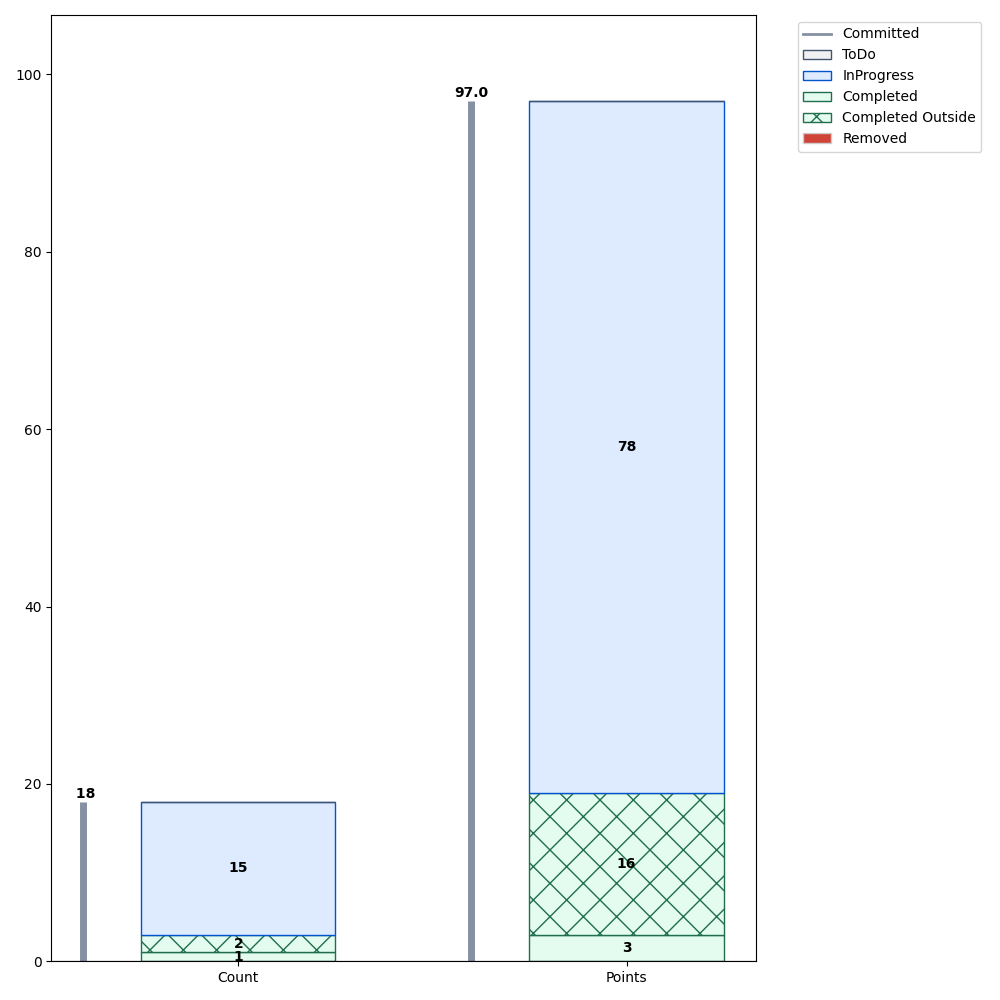
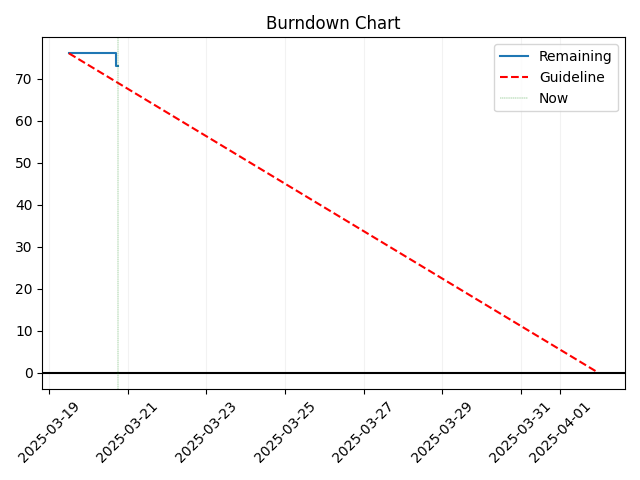

In [277]:
from IPython.display import HTML, display
from google.colab import userdata

debug_this_notebook = False

if debug_this_notebook == True:
  host = userdata.get('atlassian_host')
  if host[-1] != '/':
    host += '/'
  ultimate_sprint_report = UltimateSprintReport(
      username=userdata.get('atlassian_username'),
      password=userdata.get('atlassian_apikey'),
      jira_url=host
    )

  boardId = 364
  sprintId = 945
  project = 'FDSEWMSR'

  sprint_url = f"{host}jira/software/c/projects/{project}/boards/{boardId}/reports/sprint-retrospective?sprint={sprintId}"

  report = ultimate_sprint_report.load(sprint_url)

  display(HTML(report.show_report()))
